<a href="https://colab.research.google.com/github/thainhf/new-taggerbot-training-model/blob/main/Clean_data_taggerbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install polar
!pip install pythainlp
!pip install emoji
!pip install --upgrade gspread
!pip install openpyxl

In [2]:
import gspread as gs
import pandas as pd
import numpy as np
from google.colab import auth
auth.authenticate_user()
from google.auth import default
import nltk
import polar as pl
import sklearn
import gspread as gs
from openpyxl import load_workbook
import seaborn as sns

In [3]:
def readExcel(path):
  wb = load_workbook(filename = path)
  sheet_names = wb.get_sheet_names()
  name = sheet_names[0]
  sheet_ranges = wb[name]
  df = pd.DataFrame(sheet_ranges.values)


  df.columns = df.iloc[0]
  df = df[1:]

  #Rename duplicated columns
  cols=pd.Series(df.columns)

  for dup in cols[cols.duplicated()].unique(): 
    cols[cols[cols == dup].index.values.tolist()] = [dup + '.' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

  df.columns=cols
  return df

#df = df_from_excel('/content/drive/MyDrive/Taggerbot/Training_School_Management.xlsx')

In [4]:
#df_defin = pd.read_excel('/content/drive/MyDrive/Taggerbot/Tag_Definition.xlsx', header=0)
df_train_IPST = readExcel('/content/drive/MyDrive/Taggerbot/Training_IPST_20Expert.xlsx')
df_train_Lump100 = readExcel('/content/drive/MyDrive/Taggerbot/Training_Lumplymat_100Doc_10Expert.xlsx')
df_train_Lumpkk = readExcel('/content/drive/MyDrive/Taggerbot/Training_Lumplymat_KK_Conf.xlsx')
df_train_Qinfo = readExcel('/content/drive/MyDrive/Taggerbot/Training_Qinfo2_15Expert.xlsx')
df_train_school = readExcel('/content/drive/MyDrive/Taggerbot/Training_School_Management.xlsx')


<ipython-input-3-64e0b50a7cd4>:3: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
  sheet_names = wb.get_sheet_names()


# Cleaning Data

In [5]:
df_train_IPST = df_train_IPST.rename(columns={'name.1':'tag'})
df_train_Qinfo = df_train_Qinfo.rename(columns={'name.1':'tag'})

In [6]:
df_train_Lump100 = df_train_Lump100.rename(columns={'Tag':'tag', 'Paragraph_Text':'content'})
df_train_Lumpkk = df_train_Lumpkk.rename(columns={'Tag':'tag', 'Paragraph_Text':'content'})
df_train_school = df_train_school.rename(columns={'Tag':'tag', 'Paragraph_Text':'content'})

In [7]:
df_train_main = pd.concat([df_train_IPST[['content','tag']], df_train_Lump100[['content','tag']], df_train_Lumpkk[['content','tag']],
                           df_train_Qinfo[['content','tag']], df_train_school[['content','tag']]], axis=0)
df_train_main['tag'] = df_train_main['tag'].str.lower()

df_train_main['tag'] = df_train_main['tag'].replace('ict  literacy', 'ict literacy')
df_train_main['tag'] = df_train_main['tag'].replace('information lieteracy skill', 'information literacy skill')
df_train_main['tag'] = df_train_main['tag'].replace('media literacy', 'media literacy skills')
df_train_main['tag'] = df_train_main['tag'].replace('productivity', 'productivity and accountability')
df_train_main['tag'] = df_train_main['tag'].replace('critical thinking', 'critical thinking and problem solving')

df_train_main

,content,tag
1,สึนามิในวิดีทัศน์มีลักษณะเหมือนหรือแตกต่างจากค...,analyse
2,จากสถานการณ์ที่กำหนดให้ นักเรียนตอบคำถามลงในใบ...,analyse
3,นักเรียนแต่ละคนภายในกลุ่มนำข้อมูลที่ได้ศึกษาค้...,analyse
4,การเคลื่อนที่ของเม็ดโฟมผูกด้วยด้ายเล็ก ที่มีคว...,analyse
5,สึนามิแตกต่างจากคลื่นธรรมดาอย่างไร,analyse
...,...,...
1625,มากไปกว่านั้น เด็กๆ ยังคิดต่อได้ว่า ควรมีสาระ...,critical thinking and problem solving
1626,ในการเขียนประมวลความรู้หน่วยวิชาประยุกต์ การบ้...,information literacy skill
1627,ในการเขียนประมวลความรู้หน่วยวิชาประยุกต์ การบ้...,ict literacy
1628,ในการเขียนประมวลความรู้หน่วยวิชาประยุกต์ การบ้...,media literacy skills


In [8]:
print(len(df_train_main[df_train_main['content'].isna()]))
df_train_main = df_train_main.dropna()

0


In [9]:
print(len(set(df_train_main['tag'])), 'skills')
df_train_main['tag'].value_counts()

20 skills


critical thinking and problem solving    10084
communication skill                       5034
collaboration skill                       3867
initiative and self-direction             3127
flexibility and adaptability              1955
social and cross-cultural skills          1574
creativity and innovation                 1563
information literacy skill                1294
productivity and accountability           1286
understanding                             1040
leadership and responsibity                907
analyse                                    694
media literacy skills                      467
ict literacy                               459
evaluate                                   342
remember                                   302
apply                                      252
compassion                                 176
decision skill                             152
accountability                             137
Name: tag, dtype: int64

In [10]:
df_train_main['content'] = df_train_main['content'].str.replace('[\\<>\;\[\]\:\-*\*\$\,\.\?!"\'\^\()\&\/\{\}\|\£\«\»\’\“\”\•\•\■\™\~\=]\s*', '', regex=True)
df_train_main = df_train_main.reset_index(drop=True)
df_train_main

,content,tag
0,สึนามิในวิดีทัศน์มีลักษณะเหมือนหรือแตกต่างจากค...,analyse
1,จากสถานการณ์ที่กำหนดให้ นักเรียนตอบคำถามลงในใบ...,analyse
2,นักเรียนแต่ละคนภายในกลุ่มนำข้อมูลที่ได้ศึกษาค้...,analyse
3,การเคลื่อนที่ของเม็ดโฟมผูกด้วยด้ายเล็ก ที่มีคว...,analyse
4,สึนามิแตกต่างจากคลื่นธรรมดาอย่างไร,analyse
...,...,...
34707,มากไปกว่านั้น เด็กๆ ยังคิดต่อได้ว่า ควรมีสาระ...,critical thinking and problem solving
34708,ในการเขียนประมวลความรู้หน่วยวิชาประยุกต์ การบ้...,information literacy skill
34709,ในการเขียนประมวลความรู้หน่วยวิชาประยุกต์ การบ้...,ict literacy
34710,ในการเขียนประมวลความรู้หน่วยวิชาประยุกต์ การบ้...,media literacy skills


In [11]:
df_train_main[df_train_main.duplicated()]

,content,tag
34,สึนามิในวิดีทัศน์มีลักษณะเหมือนหรือแตกต่างจากค...,analyse
47,สึนามิในวิดีทัศน์มีลักษณะเหมือนหรือแตกต่างจากค...,analyse
56,ออกแบบแผนอพยพหนีภัยสึนามิและการสร้างเส้นทางการ...,analyse
88,2นักเรียนคิดว่า สึนามิแตกต่างจากคลื...,analyse
89,นักเรียนแต่ละกลุ่มสร้างแผนผังแนวคิดการทำงาน พร...,analyse
...,...,...
33027,ให้นักเรียนวัดความยาวฝากระป๋อง และความยาวเส้นผ...,critical thinking and problem solving
33029,ให้นักเรียนวัดความยาวถังน้ำ และความยาวเส้นผ่าน...,critical thinking and problem solving
33035,ร่วมกิจกรรมและปฏิบัติตนเป็นสมาชิกที่ดีในกลุ่ม ...,collaboration skill
33040,ร่วมกิจกรรมและปฏิบัติตนเป็นสมาชิกที่ดีในกลุ่ม ...,collaboration skill


In [12]:
df = (df_train_main.groupby(['content'])
      .agg({'tag': lambda x: ",".join(x)})
      .reset_index())
df_contain = df[df['tag'].str.contains(',')]
df_contain

,content,tag
1,ส่วนร่ว...,"collaboration skill,flexibility and adaptability"
5,นอกจากนี้ครูยังจัดที่นั...,"accountability,flexibility and adaptability"
6,ผลที่เกิดขึ้นกับเด็กทำใ...,"communication skill,collaboration skill"
9,การที่ได้นำเป้าหมายประจำสัป...,"accountability,initiative and self-direction"
12,จากเหตุการณ์ครั้งนี้ทำให้รู้ว่...,"communication skill,collaboration skill"
...,...,...
6311,๔งานการ์ตูนมีการบรรยายความรู้แทรก,"critical thinking and problem solving,communic..."
6315,๕งานโฟกัสมีการเปรียบเทียบใบพัดของพัดลมกับเฮลิค...,"critical thinking and problem solving,communic..."
6316,๕นักเรียนเป็นนักสังเกต เข้าหาความรู้ได้เอง,"productivity and accountability,accountability..."
6317,๕ประเด็นที่จะนำไปพัฒนาต่อ คือ การฝึกตั้งประเด็...,"creativity and innovation,initiative and self-..."


In [13]:
df_contain.iloc[0,0]

'                                       ส่วนร่วมในการดูแลรักษาสิ่งแวดล้อม'

# Tokenization

In [14]:
#from pythainlp.ulmfit.utils import get_texts
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus.common import thai_stopwords
from pythainlp.util import normalize

In [15]:
stopwords = list(thai_stopwords())
def tokenize(text):
  return word_tokenize(text, engine="newmm")

def remove_stop(tokens):
  return [t for t in tokens if (t not in stopwords) & (' ' not in t) & (~t.isdigit()) & (len(t)!=1)]


# Create Pipeline
pipeline = [tokenize, remove_stop]

def prepare(text, pipeline):
  tokens = text
  for transform in pipeline:
    tokens = transform(tokens)
  return tokens

In [16]:
df_train_main['token'] = df_train_main['content'].apply(prepare, pipeline=pipeline)
df_train_main['token'] = [x for x in df_train_main['token'] if x not in stopwords]
df_train_main['num_tokens'] = df_train_main['token'].map(len)
df_train_main

,content,tag,token,num_tokens
0,สึนามิในวิดีทัศน์มีลักษณะเหมือนหรือแตกต่างจากค...,analyse,"[สึนามิ, วิดีทัศน์, ลักษณะ, เหมือน, แตกต่าง, ค...",8
1,จากสถานการณ์ที่กำหนดให้ นักเรียนตอบคำถามลงในใบ...,analyse,"[สถานการณ์, กำหนดให้, นักเรียน, ตอบคำถาม, ใบ, ...",10
2,นักเรียนแต่ละคนภายในกลุ่มนำข้อมูลที่ได้ศึกษาค้...,analyse,"[นักเรียน, แต่ละคน, ข้อมูล, ศึกษา, ค้นคว้า, อภ...",24
3,การเคลื่อนที่ของเม็ดโฟมผูกด้วยด้ายเล็ก ที่มีคว...,analyse,"[เคลื่อนที่, เม็ด, โฟม, ผูก, ด้าย, ความลึก, แต...",8
4,สึนามิแตกต่างจากคลื่นธรรมดาอย่างไร,analyse,"[สึนามิ, แตกต่าง, คลื่น, ธรรมดา]",4
...,...,...,...,...
34707,มากไปกว่านั้น เด็กๆ ยังคิดต่อได้ว่า ควรมีสาระ...,critical thinking and problem solving,"[เด็ก, สาระ, ความรู้, เก, ยว, เร, อง]",7
34708,ในการเขียนประมวลความรู้หน่วยวิชาประยุกต์ การบ้...,information literacy skill,"[การเขียน, ประมวล, ความรู้, หน่วย, วิชา, ประยุ...",21
34709,ในการเขียนประมวลความรู้หน่วยวิชาประยุกต์ การบ้...,ict literacy,"[การเขียน, ประมวล, ความรู้, หน่วย, วิชา, ประยุ...",21
34710,ในการเขียนประมวลความรู้หน่วยวิชาประยุกต์ การบ้...,media literacy skills,"[การเขียน, ประมวล, ความรู้, หน่วย, วิชา, ประยุ...",21


In [17]:
[x for x in df_train_main['token']]

[['สึนามิ',
  'วิดีทัศน์',
  'ลักษณะ',
  'เหมือน',
  'แตกต่าง',
  'คลื่น',
  'ทะเล',
  'ทั่วไป'],
 ['สถานการณ์',
  'กำหนดให้',
  'นักเรียน',
  'ตอบคำถาม',
  'ใบ',
  'กิจกรรม',
  'เรื่อง',
  'ระบบ',
  'เตือนภัย',
  'สึนามิ'],
 ['นักเรียน',
  'แต่ละคน',
  'ข้อมูล',
  'ศึกษา',
  'ค้นคว้า',
  'อภิปราย',
  'แลกเปลี่ยน',
  'เรียนรู้',
  'อภิปราย',
  'ประเด็น',
  'คำถาม',
  'ที่ตั้ง',
  'พิจารณา',
  'ข้อมูล',
  'ความถูกต้อง',
  'เลือก',
  'วัสดุ',
  'ใด',
  'สร้าง',
  'เสา',
  'ส่งสัญญาณ',
  'เพราะเหตุใด',
  'คำนึงถึง',
  'ปัจจัย'],
 ['เคลื่อนที่', 'เม็ด', 'โฟม', 'ผูก', 'ด้าย', 'ความลึก', 'แตก', 'ต่างกัน'],
 ['สึนามิ', 'แตกต่าง', 'คลื่น', 'ธรรมดา'],
 ['นักเรียน',
  'ทดสอบ',
  'ทำ',
  'กำแพง',
  'ต้าน',
  'สึนามิ',
  'ออกแบบ',
  'ระบุ',
  'จุดบกพร่อง',
  'กำแพง',
  'ต้าน',
  'สึนามิ'],
 ['นักเรียน',
  'จับคู่',
  'สลับ',
  'ปล่อย',
  'น้ำ',
  'ที่ตั้ง',
  'กำแพง',
  'ต้าน',
  'สึนามิ',
  'ปล่อย',
  'น้ำ',
  'กำแพง',
  'ต้าน',
  'สึนามิ',
  'สร้าง',
  'ราง',
  'ทดสอบ',
  'กำแพง',
  'ต้าน',
  'ส

In [18]:
[x for x in df_train_main['token'][34707]]

['เด็ก', 'สาระ', 'ความรู้', 'เก', 'ยว', 'เร', 'อง']

In [19]:
df_train_main['content'][34707]

'มากไปกว่านั้น  เด็กๆ ยังคิดต่อได้ว่า ควรมีสาระความรู้เกี ยวกับเรื องนั้นแค่ไหน  '

### Check distribution

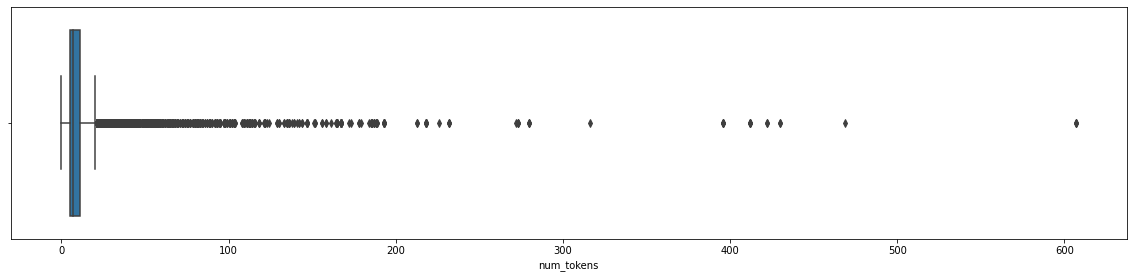

In [20]:
from matplotlib import pyplot

a4_dims = (20, 4.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.boxplot(x=df_train_main["num_tokens"])

# Modeling

In [21]:
from sklearn.model_selection import train_test_split

In [26]:
train_df = df_train_main[['token', 'tag']]

x_train, x_test, y_train, y_test = train_test_split(train_df['token'], train_df['tag'], test_size=0.33, random_state=42)

## TF-IDF (ข้ามไปก่อน)

In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MultiLabelBinarizer

In [130]:
count_vec = MultiLabelBinarizer()
mlb = count_vec.fit(df_train_main["token"])

text = df_train_main["token"].map(' '.join)
count_vec = CountVectorizer()
cv = count_vec.fit(text)

pd.DataFrame(mlb.transform(df_train_main["token"]), columns=[mlb.classes_])

,\t,\t\t,\t,,,,,,,,...,………………………………………………,……………………………………………………,………………………………………………………………,…………………………………………………………………,………………………………………………………………………,………………………………………………………………………………………………………,,,,าย
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34707,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34708,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34709,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34710,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
tfidf = TfidfTransformer()
tfidf_dt = tfidf.fit_transform(dt)
pd.DataFrame(tfidf_dt.toarray(), columns=cv.get_feature_names())

# Print how many rows and columns of the TF-IDF matrix consists
#print("n_samples: %d, n_features: %d" % vectors.shape)

## Pytorch

In [25]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

#from src import Preprocessing
#from src import TweetClassifier

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

#from src import parameter_parser

### LSTMs - Pytorch

[Text-Classification-LSTMs-PyTorch
](https://github.com/FernandoLpz/Text-Classification-LSTMs-PyTorch)

In [28]:
import argparse

def parameter_parser():

	 parser = argparse.ArgumentParser(description = "Tweet Classification")

	 parser.add_argument("--epochs",
								dest = "epochs",
								type = int,
								default = 10,
						 help = "Number of gradient descent iterations. Default is 200.")

	 parser.add_argument("--learning_rate",
								dest = "learning_rate",
								type = float,
								default = 0.01,
						 help = "Gradient descent learning rate. Default is 0.01.")

	 parser.add_argument("--hidden_dim",
								dest = "hidden_dim",
								type = int,
								default = 128,
						 help = "Number of neurons by hidden layer. Default is 128.")
						 
	 parser.add_argument("--lstm_layers",
								dest = "lstm_layers",
								type = int,
								default = 2,
					 help = "Number of LSTM layers")
					 
	 parser.add_argument("--batch_size",
									dest = "batch_size",
									type = int,
									default = 64,
							 help = "Batch size")

	 parser.add_argument("--test_size",
								dest = "test_size",
								type = float,
								default = 0.20,
						 help = "Size of test dataset. Default is 10%.")
						 
	 parser.add_argument("--max_len",
								dest = "max_len",
								type = int,
								default = 20,
						 help = "Maximum sequence length per tweet")
						 
	 parser.add_argument("--max_words",
								dest = "max_words",
								type = float,
								default = 1000,
						 help = "Maximum number of words in the dictionary")					 
	 return parser.parse_args()

In [29]:
class TweetClassifier(nn.ModuleList):

	def __init__(self, args):
		super(TweetClassifier, self).__init__()
		
		self.batch_size = args.batch_size
		self.hidden_dim = args.hidden_dim
		self.LSTM_layers = args.lstm_layers
		self.input_size = args.max_words # embedding dimention
		
		self.dropout = nn.Dropout(0.5)
		self.embedding = nn.Embedding(self.input_size, self.hidden_dim, padding_idx=0)
		self.lstm = nn.LSTM(input_size=self.hidden_dim, hidden_size=self.hidden_dim, num_layers=self.LSTM_layers, batch_first=True)
		self.fc1 = nn.Linear(in_features=self.hidden_dim, out_features=257)
		self.fc2 = nn.Linear(257, 1)
		
	def forward(self, x):
	
		h = torch.zeros((self.LSTM_layers, x.size(0), self.hidden_dim))
		c = torch.zeros((self.LSTM_layers, x.size(0), self.hidden_dim))
		
		torch.nn.init.xavier_normal_(h)
		torch.nn.init.xavier_normal_(c)

		out = self.embedding(x)
		out, (hidden, cell) = self.lstm(out, (h,c))
		out = self.dropout(out)
		out = torch.relu_(self.fc1(out[:,-1,:]))
		out = self.dropout(out)
		out = torch.sigmoid(self.fc2(out))

		return 

In [30]:
class DatasetMaper(Dataset):
	'''
	Handles batches of dataset
	'''
	def __init__(self, x, y):
		self.x = x
		self.y = y
		
	def __len__(self):
		return len(self.x)
		
	def __getitem__(self, idx):
		return self.x[idx], self.y[idx]
		

class Execute:
	'''
	Class for execution. Initializes the preprocessing as well as the 
	Tweet Classifier model
	'''

	def __init__(self, args):
		self.__init_data__(args)
		
		self.args = args
		self.batch_size = args.batch_size
		
		self.model = TweetClassifier(args)
		
	def __init_data__(self, args):
		'''
		Initialize preprocessing from raw dataset to dataset split into training and testing
		Training and test datasets are index strings that refer to tokens
		'''
		self.preprocessing = Preprocessing(args)
		self.preprocessing.load_data()
		self.preprocessing.prepare_tokens()

		raw_x_train = self.preprocessing.x_train
		raw_x_test = self.preprocessing.x_test
		
		self.y_train = self.preprocessing.y_train
		self.y_test = self.preprocessing.y_test

		self.x_train = self.preprocessing.sequence_to_token(raw_x_train)
		self.x_test = self.preprocessing.sequence_to_token(raw_x_test)
		
	def train(self):
		
		training_set = DatasetMaper(self.x_train, self.y_train)
		test_set = DatasetMaper(self.x_test, self.y_test)
		
		self.loader_training = DataLoader(training_set, batch_size=self.batch_size)
		self.loader_test = DataLoader(test_set)
		
		optimizer = optim.RMSprop(self.model.parameters(), lr=args.learning_rate)
		for epoch in range(args.epochs):
			
			predictions = []
			
			self.model.train()
			
			for x_batch, y_batch in self.loader_training:
				
				x = x_batch.type(torch.LongTensor)
				y = y_batch.type(torch.FloatTensor)
				
				y_pred = self.model(x)
				
				loss = F.binary_cross_entropy(y_pred, y)
				
				optimizer.zero_grad()
				
				loss.backward()
				
				optimizer.step()
				
				predictions += list(y_pred.squeeze().detach().numpy())
			
			test_predictions = self.evaluation()
			
			train_accuary = self.calculate_accuray(self.y_train, predictions)
			test_accuracy = self.calculate_accuray(self.y_test, test_predictions)
			
			print("Epoch: %d, loss: %.5f, Train accuracy: %.5f, Test accuracy: %.5f" % (epoch+1, loss.item(), train_accuary, test_accuracy))
			
	def evaluation(self):

		predictions = []
		self.model.eval()
		with torch.no_grad():
			for x_batch, y_batch in self.loader_test:
				x = x_batch.type(torch.LongTensor)
				y = y_batch.type(torch.FloatTensor)
				
				y_pred = self.model(x)
				predictions += list(y_pred.detach().numpy())
				
		return predictions
			
	@staticmethod
	def calculate_accuray(grand_truth, predictions):
		true_positives = 0
		true_negatives = 0
		
		for true, pred in zip(grand_truth, predictions):
			if (pred > 0.5) and (true == 1):
				true_positives += 1
			elif (pred < 0.5) and (true == 0):
				true_negatives += 1
			else:
				pass
				
		return (true_positives+true_negatives) / len(grand_truth)
	
if __name__ == "__main__":
	
	args = parameter_parser()
	
	execute = Execute(args)
	execute.train()

usage: ipykernel_launcher.py [-h] [--epochs EPOCHS]
                             [--learning_rate LEARNING_RATE]
                             [--hidden_dim HIDDEN_DIM]
                             [--lstm_layers LSTM_LAYERS]
                             [--batch_size BATCH_SIZE] [--test_size TEST_SIZE]
                             [--max_len MAX_LEN] [--max_words MAX_WORDS]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-20517913-e2b7-4b88-bafb-e763f4dd89a7.json


SystemExit: ignored

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [173]:
class DatasetMaper(Dataset):
	'''
	Handles batches of dataset
	'''
  
	def __init__(self, x, y):
		self.x = x
		self.y = y
		
	def __len__(self):
		return len(self.x)
		
	def __getitem__(self, idx):
		return self.x[idx], self.y[idx]

training_set = DatasetMaper(x_train, y_train)
test_set = DatasetMaper(x_test, y_test)
		
loader_training = DataLoader(training_set, batch_size=32)
loader_test = DataLoader(test_set)

In [174]:
# Defines a RMSprop optimizer to update the parameters
optimizer = optim.RMSprop(self.model.parameters(), lr=args.learning_rate)

for epoch in range(args.epochs):

  predictions = []

  # model in training mode
  self.model.train()

  for x_batch, y_batch in self.loader_training:

    x = x_batch.type(torch.LongTensor)
    y = y_batch.type(torch.FloatTensor)

    # Feed the model and get output "y_pred"
    y_pred = self.model(x)

    # Calculate loss
    loss = F.binary_cross_entropy(y_pred, y)

    # The gradientes are calculated
    # i.e. derivates are calculated
    loss.backward()
    
    # Each parameter is updated
    # with torch.no_grad():
    #     a -= lr * a.grad
    #     b -= lr * b.grad
    optimizer.step()
    
    # Take the gradients to zero!
    # a.grad.zero_()
    # b.grad.zero_()
    optimizer.zero_grad()

NameError: ignored